# Prediction of Winner using Logistic Regression
---

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

---
## For analysis and insights on this dataset visit <a href="https://github.com/anurag-ux/2019-general-election/blob/master/Analysis.ipynb">here</a> 

---
# Table of Contents
- Dataset Overview
- Data Preprocessing
- Handling missing values
- Managing categorical values
- Final overview before modelling data
- Learning and Predicting
- Checking the accuracy of our model

---
# Brief Overview of Dataset

In [114]:
df=pd.read_csv('dataset/LS_2.0.csv')
df.head(5)

STATE CONSTITUENCY                   NAME  WINNER PARTY SYMBOL  \
0      Telangana     ADILABAD         SOYAM BAPU RAO       1   BJP  Lotus   
1      Telangana     ADILABAD           Godam Nagesh       0   TRS    Car   
2      Telangana     ADILABAD          RATHOD RAMESH       0   INC   Hand   
3      Telangana     ADILABAD                   NOTA       0  NOTA    NaN   
4  Uttar Pradesh         AGRA  Satyapal Singh Baghel       1   BJP  Lotus   

  GENDER CRIMINAL\nCASES   AGE CATEGORY      EDUCATION  \
0   MALE              52  52.0       ST      12th Pass   
1   MALE               0  54.0       ST  Post Graduate   
2   MALE               3  52.0       ST      12th Pass   
3    NaN             NaN   NaN      NaN            NaN   
4   MALE               5  58.0       SC      Doctorate   

                        ASSETS                  LIABILITIES  GENERAL\nVOTES  \
0    Rs 30,99,414\n ~ 30 Lacs+      Rs 2,31,450\n ~ 2 Lacs+          376892   
1  Rs 1,84,77,888\n ~ 1 Crore+      Rs 8,47,000\n ~ 8 Lacs+          318665   
2  Rs 3,64,91,000\n ~ 3 Crore+  Rs 1,53,00,000\n ~ 1 Crore+          314057   
3                          NaN                          NaN           13030   
4  Rs 7,42,74,036\n ~ 7 Crore+    Rs 86,06,522\n ~ 86 Lacs+          644459   

   POSTAL\nVOTES  TOTAL\nVOTES  OVER TOTAL ELECTORS \nIN CONSTITUENCY  \
0            482        377374                              25.330684   
1            149        318814                              21.399929   
2            181        314238                              21.092771   
3              6         13036                               0.875023   
4           2416        646875                              33.383823   

   OVER TOTAL VOTES POLLED \nIN CONSTITUENCY  TOTAL ELECTORS  
0                                  35.468248         1489790  
1                                  29.964370         1489790  
2                                  29.534285         1489790  
3                                   1.225214         1489790  
4                                  56.464615         1937690

---
# Data Preprocessing
---

In [115]:
# removing non-essential columns
df.drop(['STATE','CONSTITUENCY', 'NAME','SYMBOL','GENERAL\nVOTES','TOTAL\nVOTES' ,'POSTAL\nVOTES', 'OVER TOTAL ELECTORS \nIN CONSTITUENCY','OVER TOTAL VOTES POLLED \nIN CONSTITUENCY'],axis=1,inplace=True) 

In [116]:
## cleaning data for assets column
df['ASSETS'].replace(['Not Available','Nil',np.nan,'`','Telangana'],'0',inplace=True)
a=df['ASSETS'].apply(lambda x:x.split()[1] if len(x.split())>1 else x.split()[0])
b=a.apply(lambda x:x.split(','))
c=b.apply(lambda x:''.join(x))
df['ASSETS']=c
df['ASSESTS']=df['ASSETS'].astype(int)

## cleaning data for liabilities column
df['LIABILITIES'].replace(['Not Available','Nil','NIL',np.nan,'`','Telangana'],'0',inplace=True)
a=df['LIABILITIES'].apply(lambda x:x.split()[1] if len(x.split())>1 else x.split()[0])
b=a.apply(lambda x:x.split(','))
c=b.apply(lambda x:''.join(x))
df['LIABILITIES']=c
df['LIABILITIES']=df['LIABILITIES'].astype(int)

In [117]:
# renaming some columns (duh!)
df.columns=['WINNER', 'PARTY', 'GENDER', 'CRIMINAL_CASES', 'AGE', 'CATEGORY','EDUCATION', 'ASSETS', 'LIABILITIES', 'TOTAL_ELECTORS','ASSESTS']

---
# Handling missing values
---

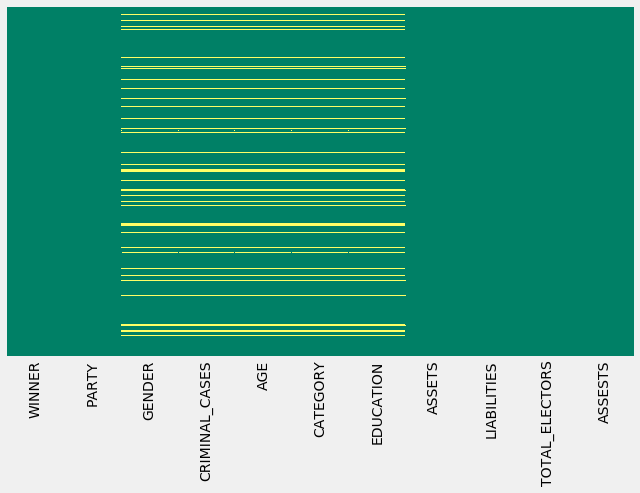

In [118]:
# visualizing the columns with null values
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='summer')
plt.show()

In [119]:
# checking the number of null values in each feature
df.isnull().sum()

WINNER              0
PARTY               0
GENDER            245
CRIMINAL_CASES    245
AGE               245
CATEGORY          245
EDUCATION         245
ASSETS              0
LIABILITIES         0
TOTAL_ELECTORS      0
ASSESTS             0
dtype: int64

#### We see that there is a strong chance that some rows have missing data in many features
#### Even if we try to fill the data for numerical values such as criminal cases, it is not possible to predict the gender or the cateogry of a candidate
#### Also our dataset has nearly 2200 rows so it is feasible to drop 245 rows for better working of our model

In [120]:
# dropping the null values
df.dropna(inplace=True)
df.isnull().sum()

WINNER            0
PARTY             0
GENDER            0
CRIMINAL_CASES    0
AGE               0
CATEGORY          0
EDUCATION         0
ASSETS            0
LIABILITIES       0
TOTAL_ELECTORS    0
ASSESTS           0
dtype: int64

In [121]:
### Noticed that the criminal cases feature has 'Not Available' value which would give an error while training our data
df['CRIMINAL_CASES']=df['CRIMINAL_CASES'].apply(lambda x:0 if x=='Not Available' else x)

---
# Managing categorical values
---

In [122]:
# we have the following categorical features in our dataset
df[['PARTY','GENDER','CATEGORY','EDUCATION']].head()

PARTY GENDER CATEGORY      EDUCATION
0   BJP   MALE       ST      12th Pass
1   TRS   MALE       ST  Post Graduate
2   INC   MALE       ST      12th Pass
4   BJP   MALE       SC      Doctorate
5   BSP   MALE       SC  Post Graduate

#### Lets focus on the PARTY feature and take a look how many categories are there in the dataset

In [123]:
df['PARTY'].value_counts()

BJP        420
INC        413
IND        201
BSP        163
CPI(M)     100
          ... 
ABGP         1
MADP         1
MOSP         1
SDF          1
SUCI(C)      1
Name: PARTY, Length: 132, dtype: int64

### As we see there are more than 130 parties. we can map all the parties with less than 10 candidates as 'Others'

In [124]:
df['PARTY']=df['PARTY'].apply(lambda x:x if df['PARTY'].value_counts().loc[x]>10 else 'Others')
df['PARTY'].value_counts()

BJP       420
INC       413
Others    251
IND       201
BSP       163
CPI(M)    100
VBA        47
AITC       47
SP         39
NTK        38
MNM        36
SHS        26
YSRCP      25
AAP        25
TDP        25
DMK        23
BJD        21
RJD        21
AIADMK     21
NCP        21
JnP        20
JD(U)      18
TRS        17
Name: PARTY, dtype: int64

### lets look at the education feature and see what can be done

In [125]:
df['EDUCATION'].value_counts()

Post Graduate            502
Graduate                 441
Graduate Professional    336
12th Pass                256
10th Pass                196
8th Pass                  78
Doctorate                 73
Others                    50
Literate                  30
5th Pass                  28
Not Available             22
Illiterate                 5
Post Graduate\n            1
Name: EDUCATION, dtype: int64

### for better working of our model lets merge some values

In [126]:
df.drop('ASSETS',axis=1,inplace=True)
ill=['Others','Not Available','Illiterate','Post Graduate\n']
df['EDUCATION']=df['EDUCATION'].apply(lambda x:'Illiterate' if x in ill else x)
df['EDUCATION'].value_counts()

Post Graduate            502
Graduate                 441
Graduate Professional    336
12th Pass                256
10th Pass                196
Illiterate                78
8th Pass                  78
Doctorate                 73
Literate                  30
5th Pass                  28
Name: EDUCATION, dtype: int64

In [127]:
df.head()

WINNER PARTY GENDER CRIMINAL_CASES   AGE CATEGORY      EDUCATION  \
0       1   BJP   MALE             52  52.0       ST      12th Pass   
1       0   TRS   MALE              0  54.0       ST  Post Graduate   
2       0   INC   MALE              3  52.0       ST      12th Pass   
4       1   BJP   MALE              5  58.0       SC      Doctorate   
5       0   BSP   MALE              0  47.0       SC  Post Graduate   

   LIABILITIES  TOTAL_ELECTORS    ASSESTS  
0       231450         1489790    3099414  
1       847000         1489790   18477888  
2     15300000         1489790   36491000  
4      8606522         1937690   74274036  
5     22251891         1937690  133784385

## Now that we have cleaned our categorical features we need to convert them into dummy values and merge them into our dataframe for the algorithm to recognize them.

In [128]:
dummy=pd.get_dummies(df[['GENDER','CATEGORY','PARTY','EDUCATION']],drop_first=True)
final=pd.concat([df,dummy],axis=1)

### Now we drop our previous categorical columns

In [129]:
final.drop(['PARTY','GENDER','CATEGORY','EDUCATION'],axis=1,inplace=True)

###### '
---
# Now that we have pre-processed our data for the machine learning algorithm lets take a final look at it

In [130]:
final.head()

WINNER CRIMINAL_CASES   AGE  LIABILITIES  TOTAL_ELECTORS    ASSESTS  \
0       1             52  52.0       231450         1489790    3099414   
1       0              0  54.0       847000         1489790   18477888   
2       0              3  52.0     15300000         1489790   36491000   
4       1              5  58.0      8606522         1937690   74274036   
5       0              0  47.0     22251891         1937690  133784385   

   GENDER_MALE  CATEGORY_SC  CATEGORY_ST  PARTY_AIADMK  ...  PARTY_YSRCP  \
0            1            0            1             0  ...            0   
1            1            0            1             0  ...            0   
2            1            0            1             0  ...            0   
4            1            1            0             0  ...            0   
5            1            1            0             0  ...            0   

   EDUCATION_12th Pass  EDUCATION_5th Pass  EDUCATION_8th Pass  \
0                    1                   0                   0   
1                    0                   0                   0   
2                    1                   0                   0   
4                    0                   0                   0   
5                    0                   0                   0   

   EDUCATION_Doctorate  EDUCATION_Graduate  EDUCATION_Graduate Professional  \
0                    0                   0                                0   
1                    0                   0                                0   
2                    0                   0                                0   
4                    1                   0                                0   
5                    0                   0                                0   

   EDUCATION_Illiterate  EDUCATION_Literate  EDUCATION_Post Graduate  
0                     0                   0                        0  
1                     0                   0                        1  
2                     0                   0                        0  
4                     0                   0                        0  
5                     0                   0                        1  

[5 rows x 40 columns]

----
# Learning and Predicting

---
#### First we break our data into the design matrix X and output vector y

In [131]:
data=final.copy()

In [132]:
X=data.drop('WINNER',axis=1)
y=data['WINNER']

### now we split our data for training and testing

In [133]:
### we'll keep 80% of our data for training and 20% for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Scaling our data to standard normal distribution

In [134]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)
df.columns

Index(['WINNER', 'PARTY', 'GENDER', 'CRIMINAL_CASES', 'AGE', 'CATEGORY',
       'EDUCATION', 'LIABILITIES', 'TOTAL_ELECTORS', 'ASSESTS'],
      dtype='object')

### Lets train our data

In [135]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(C=0.9)
lgr.fit(X_train,y_train)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Predicting the values in our test set

In [136]:
predict=lgr.predict(X_test)

#### Now we have succesfully trained and predicted values for our data so lets check how well the algorithm performed

###### `
---
## Checking the accuracy of our model (using k-fold cross validation)

In [137]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = lgr, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 85.39 %
Standard Deviation: 1.57 %


## Applying GridSearchCV

In [138]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.5,0.1,0.001,0.9,1]}]
grid_search = GridSearchCV(estimator = lgr,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)
print('Best estimator: \n\t'+str(grid_search.best_estimator_))

Best Accuracy: 85.39 %
Best Parameters: {'C': 0.9}
Best estimator: 
	LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


## Classification Report

In [139]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       376
           1       0.72      0.76      0.74       129

    accuracy                           0.86       505
   macro avg       0.82      0.83      0.82       505
weighted avg       0.87      0.86      0.86       505



## Great!! Our model has an accuracy of 85.39%
---
# Thanks for your time!!
-----